In [13]:
from utils import (
    get_text_response,
    load_yaml_to_string,
    upload_file_to_s3,
    image_to_base64
)
from termcolor import colored
import json
import sagemaker
import os
import time

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()  # execution role for the endpoint
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
prefix = "swagger_codegen"

# claude pricing in us-east-1 pricing
input_per_1k = 0.00025
output_per_1k = 0.00125

yml_dir = "yml_files"
uml_dir = "uml_diagrams"

### > Load yml files

In [26]:
prompt_template="""
You will be provided with an OpenAPI YAML file containing the specification for a set of APIs. Your
task is to generate a principle-level documentation for these APIs in JSON format.

Here are the steps you should follow:

1. Read the provided <yaml> carefully and understand the APIs, their
endpoints, request/response data structures, and other details.

<yaml>
{YAML_FILE}
</yaml>

2. In the <description> field of your JSON output, provide a comprehensive description of the APIs.
Explain what each API does, what data properties the requests take, and what the expected response
messages are. Callout any limits and frequent encoutered errors. Useexamples from the YAML file to 
illustrate your points.

3. In the <stats> field, generate some overall statistics about the APIs and present them in pullet
list sentence style, such as:
- Number of routes/endpoints?
- Number of request data models?
- Number of response data models?
- Any other relevant stats you can extract from the YAML file

4. In the <faq> field, generate a list of 20 questions and corresponding answers for a Frequently Asked
Questions (FAQ) section. Start with simple questions about the APIs and gradually increase the
complexity. The questions should cover various aspects of the APIs, such as their functionality,
data structures, error handling, and so on. The answers should be clear, concise, and informative,
using examples from the YAML file where appropriate.

5. Structure your JSON output as follows:

{
"description": "<description>",
"stats": "<stats>",
"faq": [
{
"question": "<question>",
"answer": "<answer>"
},
...
]
}

Replace <description>, <stats>, <question>, and <answer> with the appropriate content you generated
in the previous steps.

Please provide your response in JSON format only, without any additional explanations or comments.
"""

In [27]:
from IPython.display import display, Markdown

yml_file = "yml_files/petstore.yml"
yml_str = load_yaml_to_string(yml_file)


display(Markdown(f"""```yml\n{yml_str}```"""))

```yml
openapi: 3.0.0
info:
  version: 1.0.0
  title: Swagger Petstore
  description: A sample API that uses a petstore as an example to demonstrate features
    in the OpenAPI 3.0 specification
  termsOfService: http://swagger.io/terms/
  contact:
    name: Swagger API Team
    email: apiteam@swagger.io
    url: http://swagger.io
  license:
    name: Apache 2.0
    url: https://www.apache.org/licenses/LICENSE-2.0.html
servers:
- url: https://petstore.swagger.io/v2
paths:
  /pets:
    get:
      description: 'Returns all pets from the system that the user has access to

        Nam sed condimentum est. Maecenas tempor sagittis sapien, nec rhoncus sem
        sagittis sit amet. Aenean at gravida augue, ac iaculis sem. Curabitur odio
        lorem, ornare eget elementum nec, cursus id lectus. Duis mi turpis, pulvinar
        ac eros ac, tincidunt varius justo. In hac habitasse platea dictumst. Integer
        at adipiscing ante, a sagittis ligula. Aenean pharetra tempor ante molestie
        imperdiet. Vivamus id aliquam diam. Cras quis velit non tortor eleifend sagittis.
        Praesent at enim pharetra urna volutpat venenatis eget eget mauris. In eleifend
        fermentum facilisis. Praesent enim enim, gravida ac sodales sed, placerat
        id erat. Suspendisse lacus dolor, consectetur non augue vel, vehicula interdum
        libero. Morbi euismod sagittis libero sed lacinia.


        Sed tempus felis lobortis leo pulvinar rutrum. Nam mattis velit nisl, eu condimentum
        ligula luctus nec. Phasellus semper velit eget aliquet faucibus. In a mattis
        elit. Phasellus vel urna viverra, condimentum lorem id, rhoncus nibh. Ut pellentesque
        posuere elementum. Sed a varius odio. Morbi rhoncus ligula libero, vel eleifend
        nunc tristique vitae. Fusce et sem dui. Aenean nec scelerisque tortor. Fusce
        malesuada accumsan magna vel tempus. Quisque mollis felis eu dolor tristique,
        sit amet auctor felis gravida. Sed libero lorem, molestie sed nisl in, accumsan
        tempor nisi. Fusce sollicitudin massa ut lacinia mattis. Sed vel eleifend
        lorem. Pellentesque vitae felis pretium, pulvinar elit eu, euismod sapien.

        '
      operationId: findPets
      parameters:
      - name: tags
        in: query
        description: tags to filter by
        required: false
        style: form
        schema:
          type: array
          items:
            type: string
      - name: limit
        in: query
        description: maximum number of results to return
        required: false
        schema:
          type: integer
          format: int32
      responses:
        '200':
          description: pet response
          content:
            application/json:
              schema:
                type: array
                items:
                  $ref: '#/components/schemas/Pet'
        default:
          description: unexpected error
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Error'
    post:
      description: Creates a new pet in the store. Duplicates are allowed
      operationId: addPet
      requestBody:
        description: Pet to add to the store
        required: true
        content:
          application/json:
            schema:
              $ref: '#/components/schemas/NewPet'
      responses:
        '200':
          description: pet response
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Pet'
        default:
          description: unexpected error
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Error'
  /pets/{id}:
    get:
      description: Returns a user based on a single ID, if the user does not have
        access to the pet
      operationId: find pet by id
      parameters:
      - name: id
        in: path
        description: ID of pet to fetch
        required: true
        schema:
          type: integer
          format: int64
      responses:
        '200':
          description: pet response
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Pet'
        default:
          description: unexpected error
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Error'
    delete:
      description: deletes a single pet based on the ID supplied
      operationId: deletePet
      parameters:
      - name: id
        in: path
        description: ID of pet to delete
        required: true
        schema:
          type: integer
          format: int64
      responses:
        '204':
          description: pet deleted
        default:
          description: unexpected error
          content:
            application/json:
              schema:
                $ref: '#/components/schemas/Error'
components:
  schemas:
    Pet:
      allOf:
      - $ref: '#/components/schemas/NewPet'
      - type: object
        required:
        - id
        properties:
          id:
            type: integer
            format: int64
    NewPet:
      type: object
      required:
      - name
      properties:
        name:
          type: string
        tag:
          type: string
    Error:
      type: object
      required:
      - code
      - message
      properties:
        code:
          type: integer
          format: int32
        message:
          type: string
```

In [28]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [29]:
input_tokens = 0
output_tokens = 0

for yml_filename in os.listdir(yml_dir):
    # Construct the full file path
    yml_filepath = os.path.join(yml_dir, yml_filename)

    yml_str = load_yaml_to_string(yml_filepath)

    query = prompt_template.replace("{YAML_FILE}", yml_str)

    max_retries = 3
    delay = 2  # Delay in seconds between retries
    
    for attempt in range(max_retries):
        try:
    
            response = get_text_response(text_query=query)
            
            input_tokens += response["usage"]["input_tokens"]
            output_tokens += response["usage"]["output_tokens"]
            
            document_json = json.loads(response["content"][0]["text"])
            print("JSON loaded successfully...\n")
            break
        except json.JSONDecodeError as e:
            if attempt == max_retries - 1:
                print(f"Failed to load JSON after {max_retries} attempts. Skipping operation.\n")
            else:
                print(f"Failed to load JSON (attempt {attempt + 1}/{max_retries}): {e}\n")
                time.sleep(delay)
                
    # yml upload file to s3
    key = f"{prefix}/{yml_filepath}"
    s3_path = upload_file_to_s3(yml_filepath, bucket, key)
    
    print(f'yml file uploaded to {s3_path}...\n')
    
    # build the doc
    doc = f"""
    Documentation for {yml_filename.split(".")[0]}
    
    Description:
    {document_json["description"]}
    {document_json["stats"]}
    
    FAQ:
    
    """
    
    for faq in document_json["faq"]:
        doc += faq["question"] + "\n\n" + faq["answer"] + "\n\n"
        
    txt_filename = yml_filename.split(".")[0]+".txt"
    txt_filepath = f"yml_questions/{txt_filename}"
    
    with open(txt_filepath, 'w', encoding='utf-8') as file:
                file.write(doc)
    print(f'documentation generated at {txt_filepath}...\n')
    
    # txt file upload file to s3
    key = f"{prefix}/{txt_filepath}"
    metadata = {"s3_url":s3_path}
    s3_path = upload_file_to_s3(txt_filepath, bucket, key, metadata=metadata)
    
    print(f'documentation uploaded to {s3_path}...\n')
    
total_cost = (
    input_per_1k * input_tokens +
    output_per_1k * output_tokens
) / 1000

print('\n')
print('========================================================================')
print('Estimated cost:', colored(f"${total_cost}", 'green'), f"in us-east-1 region with {colored(input_tokens, 'green')} input tokens and {colored(output_tokens, 'green')} output tokens.")
print('========================================================================')

JSON loaded successfully...

File 'yml_files/petstore.yml' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_files/petstore.yml
yml file uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_files/petstore.yml...

documentation generated at yml_questions/petstore.txt...

File 'yml_questions/petstore.txt' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_questions/petstore.txt
documentation uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_questions/petstore.txt...

JSON loaded successfully...

File 'yml_files/flowerstore.yml' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_files/flowerstore.yml
yml file uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/yml_files/flowerstore.yml...

documentation generated at yml_questions/flowerstore.txt...

File 'yml_questions/flowerstore.txt' uploaded successfully to s3://sagemaker-us-west-2-37667894

### Load UML diagrams

In [30]:
prompt_template="""
You will be provided with an OpenAPI YAML file containing the specification for a set of APIs. Your
task is to generate a principle-level documentation for these APIs in JSON format.

Here are the steps you should follow:

1. Read the provided images carefully to understand the APIs, their
endpoints, request/response data structures, and other details.

2. In the <description> field of your JSON output, provide a comprehensive description of the APIs.
Explain what each API does, what data properties the requests take, and what the expected response
messages are. Callout any limits and frequent encoutered errors. Useexamples from the YAML file to 
illustrate your points.

3. In the <stats> field, generate some overall statistics about the APIs and present them in pullet
list sentence style, such as:
- Number of routes/endpoints?
- Number of request data models?
- Number of response data models?
- Any other relevant stats you can extract from the YAML file

4. In the <faq> field, generate a list of 20 questions and corresponding answers for a Frequently Asked
Questions (FAQ) section. Start with simple questions about the APIs and gradually increase the
complexity. The questions should cover various aspects of the APIs, such as their functionality,
data structures, error handling, and so on. The answers should be clear, concise, and informative,
using examples from the YAML file where appropriate.

5. Structure your JSON output as follows:

{
"description": "<description>",
"stats": "<stats>",
"faq": [
{
"question": "<question>",
"answer": "<answer>"
},
...
]
}

Replace <description>, <stats>, <question>, and <answer> with the appropriate content you generated
in the previous steps.

Please provide your response in JSON format only, without any additional explanations or comments.
"""

prompt_template ="""
You will be generating principle level documentation for a set of Swagger APIs provided in UML diagram
images. Here are the steps to follow:

1. Read the provided images carefully to understand the APIs, their endpoints, parameters,
request/response formats, etc.

2. In the <description> section, provide a high-level overview of what the APIs do and how they can
be used. Explain the different endpoints, their purposes, authentication requirements (if any), etc.

3. In the <faq> section, generate a list of at least 10 frequently asked questions (FAQs) related to
the APIs along with their answers. The questions should cover common use cases, error scenarios,
authentication issues, etc. that a developer might face while integrating with the APIs.

4. Structure your response in JSON format with the following keys:

{
"description": "<description>",
"faq": [
{
"question": "<question1>",
"answer": "<answer1>"
},
{
"question": "<question2>",
"answer": "<answer2>"
},
...
]
}


Replace <description> with the overview description you wrote in step 2.
Replace <question1>, <answer1>, <question2>, <answer2>, etc. with the FAQ questions and answers you
generated in step 3.

Make sure to provide a comprehensive and easy-to-understand documentation that will help developers
quickly get started with the APIs. Output the JSON only, do not provide any explanations.
"""

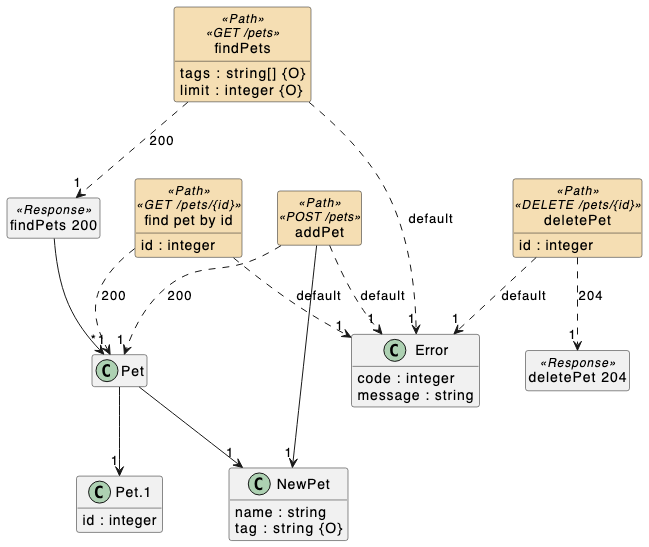

In [31]:
from PIL import Image
from IPython.display import display

# Open the JPG image file
image = Image.open("uml_diagrams/petstore.jpg")
image = image.convert("RGB")
display(image)

In [32]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [34]:
input_tokens = 0
output_tokens = 0

for uml_filename in os.listdir(uml_dir):
    # Construct the full file path
    uml_filepath = os.path.join(uml_dir, uml_filename)

    image = Image.open(uml_filepath)
    image = image.convert("RGB")

    query = prompt_template

    max_retries = 3
    delay = 2  # Delay in seconds between retries
    
    for attempt in range(max_retries):
        try:
    
            response = get_text_response(image_base64=image_to_base64(image),text_query=query)
            
            input_tokens += response["usage"]["input_tokens"]
            output_tokens += response["usage"]["output_tokens"]
            
            document_json = json.loads(response["content"][0]["text"])
            print("JSON loaded successfully...\n")
            break
        except json.JSONDecodeError as e:
            if attempt == max_retries - 1:
                print(f"Failed to load JSON after {max_retries} attempts. Skipping operation.\n")
            else:
                print(f"Failed to load JSON (attempt {attempt + 1}/{max_retries}): {e}\n")
                time.sleep(delay)
                
    # yml upload file to s3
    key = f"{prefix}/{uml_filepath}"
    s3_path = upload_file_to_s3(uml_filepath, bucket, key)
    
    print(f'yml file uploaded to {s3_path}...\n')
    
    # build the doc
    doc = f"""
    Documentation for {yml_filename.split(".")[0]}
    
    Description:
    {document_json["description"]}
    {document_json["stats"]}
    
    FAQ:
    
    """
    
    for faq in document_json["faq"]:
        doc += faq["question"] + "\n\n" + faq["answer"] + "\n\n"
        
    txt_filename = uml_filename.split(".")[0]+".txt"
    txt_filepath = f"uml_questions/{txt_filename}"
    
    with open(txt_filepath, 'w', encoding='utf-8') as file:
                file.write(doc)
    print(f'documentation generated at {txt_filepath}...\n')
    
    # txt file upload file to s3
    key = f"{prefix}/{txt_filepath}"
    metadata = {"s3_url":s3_path}
    s3_path = upload_file_to_s3(txt_filepath, bucket, key, metadata=metadata)
    
    print(f'documentation uploaded to {s3_path}...\n')
    
total_cost = (
    input_per_1k * input_tokens +
    output_per_1k * output_tokens
) / 1000

print('\n')
print('========================================================================')
print('Estimated cost:', colored(f"${total_cost}", 'green'), f"in us-east-1 region with {colored(input_tokens, 'green')} input tokens and {colored(output_tokens, 'green')} output tokens.")
print('========================================================================')

JSON loaded successfully...

File 'uml_diagrams/petstore.jpg' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_diagrams/petstore.jpg
yml file uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_diagrams/petstore.jpg...

documentation generated at uml_questions/petstore.txt...

File 'uml_questions/petstore.txt' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_questions/petstore.txt
documentation uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_questions/petstore.txt...

JSON loaded successfully...

File 'uml_diagrams/flowerstore.jpg' uploaded successfully to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_diagrams/flowerstore.jpg
yml file uploaded to s3://sagemaker-us-west-2-376678947624/swagger_codegen/uml_diagrams/flowerstore.jpg...

documentation generated at uml_questions/flowerstore.txt...

File 'uml_questions/flowerstore.txt' uploaded successfully to s3://sagemaker-

In [35]:
%store bucket
%store prefix
%store yml_dir
%store uml_dir

Stored 'bucket' (str)
Stored 'prefix' (str)
Stored 'yml_dir' (str)
Stored 'uml_dir' (str)
